This UFC project takes fight data from 1993 to 2023 and utilizes various machine learning models to predict the probabilities of future fights.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

pd.set_option('display.max_columns', None)

In [3]:
df = pd.read_csv('./data/raw_total_fight_data.csv', sep = ';') # ; For fixing formatting

In [4]:
df.head()

,R_fighter,B_fighter,R_KD,B_KD,R_SIG_STR.,B_SIG_STR.,R_SIG_STR_pct,B_SIG_STR_pct,R_TOTAL_STR.,B_TOTAL_STR.,R_TD,B_TD,R_TD_pct,B_TD_pct,R_SUB_ATT,B_SUB_ATT,R_REV,B_REV,R_CTRL,B_CTRL,R_HEAD,B_HEAD,R_BODY,B_BODY,R_LEG,B_LEG,R_DISTANCE,B_DISTANCE,R_CLINCH,B_CLINCH,R_GROUND,B_GROUND,win_by,last_round,last_round_time,Format,Referee,date,location,Fight_type,Winner
0,Nate Landwehr,Dooho Choi,0,0,21 of 55,63 of 95,38%,66%,27 of 64,66 of 98,0 of 0,3 of 4,---,75%,0,0,0,0,0:42,4:24,9 of 35,47 of 78,9 of 15,9 of 9,3 of 5,7 of 8,11 of 43,56 of 88,10 of 12,4 of 4,0 of 0,3 of 3,KO/TKO,3,3:21,3 Rnd (5-5-5),Chris Tognoni,"December 07, 2024","Las Vegas, Nevada, USA",Featherweight Bout,Dooho Choi
1,Vicente Luque,Themba Gorimbo,0,0,2 of 6,5 of 9,33%,55%,2 of 6,5 of 9,0 of 0,0 of 0,---,---,1,0,0,0,0:14,0:00,1 of 4,1 of 5,0 of 0,1 of 1,1 of 2,3 of 3,2 of 6,5 of 9,0 of 0,0 of 0,0 of 0,0 of 0,Submission,1,0:52,3 Rnd (5-5-5),Mark Smith,"December 07, 2024","Las Vegas, Nevada, USA",Welterweight Bout,Vicente Luque
2,Dominick Reyes,Anthony Smith,0,0,121 of 162,21 of 46,74%,45%,172 of 232,24 of 49,0 of 0,0 of 4,---,0%,0,0,0,0,3:51,0:01,110 of 149,14 of 36,8 of 10,5 of 7,3 of 3,2 of 3,48 of 75,19 of 43,17 of 22,2 of 3,56 of 65,0 of 0,KO/TKO,2,4:46,3 Rnd (5-5-5),Marc Goddard,"December 07, 2024","Las Vegas, Nevada, USA",Light Heavyweight Bout,Dominick Reyes
3,Movsar Evloev,Aljamain Sterling,0,0,8 of 26,12 of 26,30%,46%,136 of 165,45 of 67,4 of 5,6 of 8,80%,75%,0,0,1,2,6:09,6:16,6 of 23,7 of 16,1 of 1,5 of 8,1 of 2,0 of 2,6 of 22,9 of 23,0 of 1,2 of 2,2 of 3,1 of 1,Decision - Unanimous,3,5:00,3 Rnd (5-5-5),Jason Herzog,"December 07, 2024","Las Vegas, Nevada, USA",Featherweight Bout,Movsar Evloev
4,Chris Weidman,Eryk Anders,1,0,16 of 36,62 of 102,44%,60%,27 of 50,121 of 193,0 of 1,0 of 6,0%,0%,1,0,0,0,2:15,4:24,11 of 30,56 of 96,5 of 6,6 of 6,0 of 0,0 of 0,12 of 23,7 of 25,0 of 2,7 of 12,4 of 11,48 of 65,KO/TKO,2,4:51,3 Rnd (5-5-5),Mark Smith,"December 07, 2024","Las Vegas, Nevada, USA",Catch Weight Bout,Eryk Anders


In [5]:
df.shape

(7919, 41)

# **Data Cleaning**

We drop columns that are not relevant to our models and rename abreviations to its full definition

In [6]:
to_drop = ['R_REV','B_REV','R_HEAD', 'B_HEAD', 'R_BODY', 'B_BODY', 'R_LEG', 'B_LEG', 'R_DISTANCE', 'B_DISTANCE', 'R_CLINCH', 'B_CLINCH']
df = df.drop(to_drop, axis=1)

In [7]:
to_drop2 = ['Referee','location']
df = df.drop(to_drop2, axis=1)

In [8]:
df['Format'] = df['Format'].str.extract(r'(\d+)')
df = df.rename(columns={'Format': 'No_of_rounds'})
df = df.rename(columns={'R_KD': 'R_Knockdown'})
df = df.rename(columns={'B_KD': 'B_Knockdown'})

In [9]:
df = df.rename(columns={'R_SIG_STR.': 'R_Significant_Strikes'})
df = df.rename(columns={'B_SIG_STR.': 'B_Significant_Strikes'})

df = df.rename(columns={'R_SIG_STR_pct': 'R_Significant_Strike_Percent'})
df = df.rename(columns={'B_SIG_STR_pct': 'B_Significant_Strike_Percent'})

In [10]:
df = df.rename(columns={'R_TOTAL_STR.': 'R_Total_Strikes'})
df = df.rename(columns={'B_TOTAL_STR.': 'B_Total_Strikes'})

In [11]:
df = df.rename(columns={'R_TD': 'R_Takedowns'})
df = df.rename(columns={'B_TD': 'B_Takedowns'})

In [12]:
df = df.rename(columns={'R_TD_pct': 'R_Takedown_Percent'})
df = df.rename(columns={'B_TD_pct': 'B_Takedown_Percent'})

In [13]:
df = df.rename(columns={'R_SUB_ATT': 'R_Submission_Attempt'})
df = df.rename(columns={'B_SUB_ATT': 'B_Submission_Attempt'})

In [14]:
df = df.rename(columns={'R_CTRL': 'R_Ground_Control'})
df = df.rename(columns={'B_CTRL': 'B_Ground_Control'})

In [15]:
df = df.rename(columns={'R_GROUND': 'R_Ground_Strikes'})
df = df.rename(columns={'B_GROUND': 'B_Ground_Strikes'})

In [16]:
df.head()

,R_fighter,B_fighter,R_Knockdown,B_Knockdown,R_Significant_Strikes,B_Significant_Strikes,R_Significant_Strike_Percent,B_Significant_Strike_Percent,R_Total_Strikes,B_Total_Strikes,R_Takedowns,B_Takedowns,R_Takedown_Percent,B_Takedown_Percent,R_Submission_Attempt,B_Submission_Attempt,R_Ground_Control,B_Ground_Control,R_Ground_Strikes,B_Ground_Strikes,win_by,last_round,last_round_time,No_of_rounds,date,Fight_type,Winner
0,Nate Landwehr,Dooho Choi,0,0,21 of 55,63 of 95,38%,66%,27 of 64,66 of 98,0 of 0,3 of 4,---,75%,0,0,0:42,4:24,0 of 0,3 of 3,KO/TKO,3,3:21,3,"December 07, 2024",Featherweight Bout,Dooho Choi
1,Vicente Luque,Themba Gorimbo,0,0,2 of 6,5 of 9,33%,55%,2 of 6,5 of 9,0 of 0,0 of 0,---,---,1,0,0:14,0:00,0 of 0,0 of 0,Submission,1,0:52,3,"December 07, 2024",Welterweight Bout,Vicente Luque
2,Dominick Reyes,Anthony Smith,0,0,121 of 162,21 of 46,74%,45%,172 of 232,24 of 49,0 of 0,0 of 4,---,0%,0,0,3:51,0:01,56 of 65,0 of 0,KO/TKO,2,4:46,3,"December 07, 2024",Light Heavyweight Bout,Dominick Reyes
3,Movsar Evloev,Aljamain Sterling,0,0,8 of 26,12 of 26,30%,46%,136 of 165,45 of 67,4 of 5,6 of 8,80%,75%,0,0,6:09,6:16,2 of 3,1 of 1,Decision - Unanimous,3,5:00,3,"December 07, 2024",Featherweight Bout,Movsar Evloev
4,Chris Weidman,Eryk Anders,1,0,16 of 36,62 of 102,44%,60%,27 of 50,121 of 193,0 of 1,0 of 6,0%,0%,1,0,2:15,4:24,4 of 11,48 of 65,KO/TKO,2,4:51,3,"December 07, 2024",Catch Weight Bout,Eryk Anders


Remove 'of'

In [17]:
df[['R_Significant_Strikes_Landed', 'R_Significant_Strikes_Attempted']] = df['R_Significant_Strikes'].str.split(' of ', expand=True)
df[['B_Significant_Strikes_Landed', 'B_Significant_Strikes_Attempted']] = df['B_Significant_Strikes'].str.split(' of ', expand=True)

to_drop3 = ['R_Significant_Strikes','B_Significant_Strikes']
df = df.drop(to_drop3, axis=1)


In [18]:
df[['R_Total_Strikes_Landed', 'R_Total_Strikes_Attempted']] = df['R_Total_Strikes'].str.split(' of ', expand=True)
df[['B_Total_Strikes_Landed', 'B_Total_Strikes_Attempted']] = df['B_Total_Strikes'].str.split(' of ', expand=True)

to_drop3 = ['R_Total_Strikes','B_Total_Strikes']
df = df.drop(to_drop3, axis=1)

In [19]:
df[['R_Takedowns_Landed', 'R_Takedowns_Attempted']] = df['R_Takedowns'].str.split(' of ', expand=True)
df[['B_Takedowns_Landed', 'B_Takedowns_Attempted']] = df['B_Takedowns'].str.split(' of ', expand=True)

to_drop3 = ['R_Takedowns','B_Takedowns']
df = df.drop(to_drop3, axis=1)

In [20]:
df[['R_Ground_Strikes_Landed', 'R_Ground_Strikes_Attempted']] = df['R_Ground_Strikes'].str.split(' of ', expand=True)
df[['B_Ground_Strikes_Landed', 'B_Ground_Strikes_Attempted']] = df['B_Ground_Strikes'].str.split(' of ', expand=True)

to_drop3 = ['R_Ground_Strikes','B_Ground_Strikes']
df = df.drop(to_drop3, axis=1)

Remove the '%' symbol from the values in the column

In [21]:
df['R_Significant_Strike_Percent'] = df['R_Significant_Strike_Percent'].str.replace('%', '')
df['B_Significant_Strike_Percent'] = df['B_Significant_Strike_Percent'].str.replace('%', '')
df['R_Takedown_Percent'] = df['R_Takedown_Percent'].str.replace('%', '')
df['B_Takedown_Percent'] = df['B_Takedown_Percent'].str.replace('%', '')

In [22]:
df['R_Significant_Strike_Percent'] = df['R_Significant_Strike_Percent'].str.replace('---', '0')
df['B_Significant_Strike_Percent'] = df['B_Significant_Strike_Percent'].str.replace('---', '0')
df['R_Takedown_Percent'] = df['R_Takedown_Percent'].str.replace('---', '0')
df['B_Takedown_Percent'] = df['B_Takedown_Percent'].str.replace('---', '0')

In [23]:
df.shape

(7919, 35)

In [24]:
print(df['date'].dtype)

object


In [25]:
df['date'] = pd.to_datetime(df['date'], format="%B %d, %Y").dt.strftime("%Y-%m-%d")

Before April 2001, there were no rules in UFC with different rules to the sport, hence we will only consider fights after this date.

In [26]:
limit_date = '2001-04-01'
df = df[(df['date'] > limit_date)]
print(df.shape)

(7665, 35)


In [27]:
df.head()

,R_fighter,B_fighter,R_Knockdown,B_Knockdown,R_Significant_Strike_Percent,B_Significant_Strike_Percent,R_Takedown_Percent,B_Takedown_Percent,R_Submission_Attempt,B_Submission_Attempt,R_Ground_Control,B_Ground_Control,win_by,last_round,last_round_time,No_of_rounds,date,Fight_type,Winner,R_Significant_Strikes_Landed,R_Significant_Strikes_Attempted,B_Significant_Strikes_Landed,B_Significant_Strikes_Attempted,R_Total_Strikes_Landed,R_Total_Strikes_Attempted,B_Total_Strikes_Landed,B_Total_Strikes_Attempted,R_Takedowns_Landed,R_Takedowns_Attempted,B_Takedowns_Landed,B_Takedowns_Attempted,R_Ground_Strikes_Landed,R_Ground_Strikes_Attempted,B_Ground_Strikes_Landed,B_Ground_Strikes_Attempted
0,Nate Landwehr,Dooho Choi,0,0,38,66,0,75,0,0,0:42,4:24,KO/TKO,3,3:21,3,2024-12-07,Featherweight Bout,Dooho Choi,21,55,63,95,27,64,66,98,0,0,3,4,0,0,3,3
1,Vicente Luque,Themba Gorimbo,0,0,33,55,0,0,1,0,0:14,0:00,Submission,1,0:52,3,2024-12-07,Welterweight Bout,Vicente Luque,2,6,5,9,2,6,5,9,0,0,0,0,0,0,0,0
2,Dominick Reyes,Anthony Smith,0,0,74,45,0,0,0,0,3:51,0:01,KO/TKO,2,4:46,3,2024-12-07,Light Heavyweight Bout,Dominick Reyes,121,162,21,46,172,232,24,49,0,0,0,4,56,65,0,0
3,Movsar Evloev,Aljamain Sterling,0,0,30,46,80,75,0,0,6:09,6:16,Decision - Unanimous,3,5:00,3,2024-12-07,Featherweight Bout,Movsar Evloev,8,26,12,26,136,165,45,67,4,5,6,8,2,3,1,1
4,Chris Weidman,Eryk Anders,1,0,44,60,0,0,1,0,2:15,4:24,KO/TKO,2,4:51,3,2024-12-07,Catch Weight Bout,Eryk Anders,16,36,62,102,27,50,121,193,0,1,0,6,4,11,48,65


In [28]:
print(df['win_by'].unique())

['KO/TKO' 'Submission' 'Decision - Unanimous' 'Decision - Split'
 "TKO - Doctor's Stoppage" 'Could Not Continue' 'Decision - Majority' 'DQ'
 'Overturned']


Removing NaN rows in Winner column.

In [29]:
df = df.dropna(subset=['Winner'])

In [30]:
print("Total NaN in dataframe :" , df.isna().sum().sum())
print("Total NaN in each column of the dataframe")
na = []
for index, col in enumerate(df):
    na.append((index, df[col].isna().sum())) 
na_sorted = na.copy()
na_sorted.sort(key = lambda x: x[1], reverse = True) 

for i in range(len(df.columns)):
    print(df.columns[na_sorted[i][0]],":", na_sorted[i][1], "NaN")

Total NaN in dataframe : 0
Total NaN in each column of the dataframe
R_fighter : 0 NaN
B_fighter : 0 NaN
R_Knockdown : 0 NaN
B_Knockdown : 0 NaN
R_Significant_Strike_Percent : 0 NaN
B_Significant_Strike_Percent : 0 NaN
R_Takedown_Percent : 0 NaN
B_Takedown_Percent : 0 NaN
R_Submission_Attempt : 0 NaN
B_Submission_Attempt : 0 NaN
R_Ground_Control : 0 NaN
B_Ground_Control : 0 NaN
win_by : 0 NaN
last_round : 0 NaN
last_round_time : 0 NaN
No_of_rounds : 0 NaN
date : 0 NaN
Fight_type : 0 NaN
Winner : 0 NaN
R_Significant_Strikes_Landed : 0 NaN
R_Significant_Strikes_Attempted : 0 NaN
B_Significant_Strikes_Landed : 0 NaN
B_Significant_Strikes_Attempted : 0 NaN
R_Total_Strikes_Landed : 0 NaN
R_Total_Strikes_Attempted : 0 NaN
B_Total_Strikes_Landed : 0 NaN
B_Total_Strikes_Attempted : 0 NaN
R_Takedowns_Landed : 0 NaN
R_Takedowns_Attempted : 0 NaN
B_Takedowns_Landed : 0 NaN
B_Takedowns_Attempted : 0 NaN
R_Ground_Strikes_Landed : 0 NaN
R_Ground_Strikes_Attempted : 0 NaN
B_Ground_Strikes_Landed : 0 

We have now finished cleaning the dataset by removing all NaN rows

# **Feature Engineering and EDA**

In [31]:
def calculate_total_duration(value):
    parts = value.split(':')
    minutes = int(parts[0])
    seconds = int(parts[1])
    total_seconds = minutes * 60 + seconds
    return total_seconds


df['last_round_time'] = df['last_round_time'].apply(calculate_total_duration)


In [32]:
df['time_fought'] = (df['last_round'] - 1) * 5 * 60 + df['last_round_time']

In [33]:
to_drop = ['last_round','last_round_time']
df = df.drop(to_drop, axis=1)

In [34]:
df.head()

,R_fighter,B_fighter,R_Knockdown,B_Knockdown,R_Significant_Strike_Percent,B_Significant_Strike_Percent,R_Takedown_Percent,B_Takedown_Percent,R_Submission_Attempt,B_Submission_Attempt,R_Ground_Control,B_Ground_Control,win_by,No_of_rounds,date,Fight_type,Winner,R_Significant_Strikes_Landed,R_Significant_Strikes_Attempted,B_Significant_Strikes_Landed,B_Significant_Strikes_Attempted,R_Total_Strikes_Landed,R_Total_Strikes_Attempted,B_Total_Strikes_Landed,B_Total_Strikes_Attempted,R_Takedowns_Landed,R_Takedowns_Attempted,B_Takedowns_Landed,B_Takedowns_Attempted,R_Ground_Strikes_Landed,R_Ground_Strikes_Attempted,B_Ground_Strikes_Landed,B_Ground_Strikes_Attempted,time_fought
0,Nate Landwehr,Dooho Choi,0,0,38,66,0,75,0,0,0:42,4:24,KO/TKO,3,2024-12-07,Featherweight Bout,Dooho Choi,21,55,63,95,27,64,66,98,0,0,3,4,0,0,3,3,801
1,Vicente Luque,Themba Gorimbo,0,0,33,55,0,0,1,0,0:14,0:00,Submission,3,2024-12-07,Welterweight Bout,Vicente Luque,2,6,5,9,2,6,5,9,0,0,0,0,0,0,0,0,52
2,Dominick Reyes,Anthony Smith,0,0,74,45,0,0,0,0,3:51,0:01,KO/TKO,3,2024-12-07,Light Heavyweight Bout,Dominick Reyes,121,162,21,46,172,232,24,49,0,0,0,4,56,65,0,0,586
3,Movsar Evloev,Aljamain Sterling,0,0,30,46,80,75,0,0,6:09,6:16,Decision - Unanimous,3,2024-12-07,Featherweight Bout,Movsar Evloev,8,26,12,26,136,165,45,67,4,5,6,8,2,3,1,1,900
4,Chris Weidman,Eryk Anders,1,0,44,60,0,0,1,0,2:15,4:24,KO/TKO,3,2024-12-07,Catch Weight Bout,Eryk Anders,16,36,62,102,27,50,121,193,0,1,0,6,4,11,48,65,591


In [35]:
df_DQ = df[df['win_by'] == 'DQ']

df_DQ.head(2)

,R_fighter,B_fighter,R_Knockdown,B_Knockdown,R_Significant_Strike_Percent,B_Significant_Strike_Percent,R_Takedown_Percent,B_Takedown_Percent,R_Submission_Attempt,B_Submission_Attempt,R_Ground_Control,B_Ground_Control,win_by,No_of_rounds,date,Fight_type,Winner,R_Significant_Strikes_Landed,R_Significant_Strikes_Attempted,B_Significant_Strikes_Landed,B_Significant_Strikes_Attempted,R_Total_Strikes_Landed,R_Total_Strikes_Attempted,B_Total_Strikes_Landed,B_Total_Strikes_Attempted,R_Takedowns_Landed,R_Takedowns_Attempted,B_Takedowns_Landed,B_Takedowns_Attempted,R_Ground_Strikes_Landed,R_Ground_Strikes_Attempted,B_Ground_Strikes_Landed,B_Ground_Strikes_Attempted,time_fought
295,Piera Rodriguez,Ariane Carnelossi,1,0,49,32,50,0,0,0,3:53,0:00,DQ,3,2024-05-18,Women's Strawweight Bout,Ariane Carnelossi,40,81,16,49,51,102,46,89,1,2,0,0,7,8,0,0,496
387,Igor Severino,Andre Lima,0,0,46,51,55,50,0,2,3:00,0:24,DQ,3,2024-03-23,Flyweight Bout,Andre Lima,36,78,30,58,40,85,38,66,5,9,1,2,1,2,0,0,472


In [36]:
 df = df.drop(df[df['win_by'] == 'DQ'].index)

In [37]:
df_DQ = df[df['win_by'] == 'DQ']
df_DQ.head(2)

,R_fighter,B_fighter,R_Knockdown,B_Knockdown,R_Significant_Strike_Percent,B_Significant_Strike_Percent,R_Takedown_Percent,B_Takedown_Percent,R_Submission_Attempt,B_Submission_Attempt,R_Ground_Control,B_Ground_Control,win_by,No_of_rounds,date,Fight_type,Winner,R_Significant_Strikes_Landed,R_Significant_Strikes_Attempted,B_Significant_Strikes_Landed,B_Significant_Strikes_Attempted,R_Total_Strikes_Landed,R_Total_Strikes_Attempted,B_Total_Strikes_Landed,B_Total_Strikes_Attempted,R_Takedowns_Landed,R_Takedowns_Attempted,B_Takedowns_Landed,B_Takedowns_Attempted,R_Ground_Strikes_Landed,R_Ground_Strikes_Attempted,B_Ground_Strikes_Landed,B_Ground_Strikes_Attempted,time_fought


Creating two separate dataframes for R and B, and will combine them vertically afterwards.

In [38]:
R_subset = ['R_fighter','R_Knockdown','R_Significant_Strike_Percent','R_Takedown_Percent', 'R_Submission_Attempt','R_Ground_Control', 'win_by', 'No_of_rounds', 'date', 'Fight_type',
            'R_Significant_Strikes_Landed', 'R_Significant_Strikes_Attempted', 'R_Total_Strikes_Landed', 'R_Total_Strikes_Attempted', 'R_Takedowns_Landed', 'R_Takedowns_Attempted', 
            'R_Ground_Strikes_Landed', 'time_fought','Winner']
R_df = df[R_subset]
R_df = R_df.rename(columns=lambda x: x.replace('R_', ''))

R_df['Winner'] = np.where(R_df['Winner'] == R_df['fighter'], 1, 0)

R_df.head()

,fighter,Knockdown,Significant_Strike_Percent,Takedown_Percent,Submission_Attempt,Ground_Control,win_by,No_of_rounds,date,Fight_type,Significant_Strikes_Landed,Significant_Strikes_Attempted,Total_Strikes_Landed,Total_Strikes_Attempted,Takedowns_Landed,Takedowns_Attempted,Ground_Strikes_Landed,time_fought,Winner
0,Nate Landwehr,0,38,0,0,0:42,KO/TKO,3,2024-12-07,Featherweight Bout,21,55,27,64,0,0,0,801,0
1,Vicente Luque,0,33,0,1,0:14,Submission,3,2024-12-07,Welterweight Bout,2,6,2,6,0,0,0,52,1
2,Dominick Reyes,0,74,0,0,3:51,KO/TKO,3,2024-12-07,Light Heavyweight Bout,121,162,172,232,0,0,56,586,1
3,Movsar Evloev,0,30,80,0,6:09,Decision - Unanimous,3,2024-12-07,Featherweight Bout,8,26,136,165,4,5,2,900,1
4,Chris Weidman,1,44,0,1,2:15,KO/TKO,3,2024-12-07,Catch Weight Bout,16,36,27,50,0,1,4,591,0


In [39]:
B_subset = ['B_fighter', 'B_Knockdown', 'B_Significant_Strike_Percent', 'B_Takedown_Percent', 'B_Submission_Attempt',
            'B_Ground_Control', 'win_by', 'No_of_rounds', 'date', 'Fight_type', 'B_Significant_Strikes_Landed',
            'B_Significant_Strikes_Attempted', 'B_Total_Strikes_Landed', 'B_Total_Strikes_Attempted', 
            'B_Takedowns_Landed', 'B_Takedowns_Attempted', 'B_Ground_Strikes_Landed', 'time_fought', 'Winner']
B_df = df[B_subset]
B_df = B_df.rename(columns=lambda x: x.replace('B_', ''))
B_df['Winner'] = np.where(B_df['Winner'] == B_df['fighter'], 1, 0)


B_df.head()

,fighter,Knockdown,Significant_Strike_Percent,Takedown_Percent,Submission_Attempt,Ground_Control,win_by,No_of_rounds,date,Fight_type,Significant_Strikes_Landed,Significant_Strikes_Attempted,Total_Strikes_Landed,Total_Strikes_Attempted,Takedowns_Landed,Takedowns_Attempted,Ground_Strikes_Landed,time_fought,Winner
0,Dooho Choi,0,66,75,0,4:24,KO/TKO,3,2024-12-07,Featherweight Bout,63,95,66,98,3,4,3,801,1
1,Themba Gorimbo,0,55,0,0,0:00,Submission,3,2024-12-07,Welterweight Bout,5,9,5,9,0,0,0,52,0
2,Anthony Smith,0,45,0,0,0:01,KO/TKO,3,2024-12-07,Light Heavyweight Bout,21,46,24,49,0,4,0,586,0
3,Aljamain Sterling,0,46,75,0,6:16,Decision - Unanimous,3,2024-12-07,Featherweight Bout,12,26,45,67,6,8,1,900,0
4,Eryk Anders,0,60,0,0,4:24,KO/TKO,3,2024-12-07,Catch Weight Bout,62,102,121,193,0,6,48,591,1


In [40]:
new_df = pd.concat([R_df, B_df])

# sort the combined dataframe by date
ufc = new_df.sort_values(by='date', ascending=False)
# reset the index
ufc = ufc.reset_index(drop=True)


In [41]:
ufc['Ground_Control'] = ufc['Ground_Control'].apply(calculate_total_duration)

In [42]:
ufc.head()

,fighter,Knockdown,Significant_Strike_Percent,Takedown_Percent,Submission_Attempt,Ground_Control,win_by,No_of_rounds,date,Fight_type,Significant_Strikes_Landed,Significant_Strikes_Attempted,Total_Strikes_Landed,Total_Strikes_Attempted,Takedowns_Landed,Takedowns_Attempted,Ground_Strikes_Landed,time_fought,Winner
0,Nate Landwehr,0,38,0,0,42,KO/TKO,3,2024-12-07,Featherweight Bout,21,55,27,64,0,0,0,801,0
1,Vicente Luque,0,33,0,1,14,Submission,3,2024-12-07,Welterweight Bout,2,6,2,6,0,0,0,52,1
2,Lukasz Brzeski,0,46,0,0,0,KO/TKO,3,2024-12-07,Heavyweight Bout,32,69,32,69,0,2,0,291,0
3,Max Griffin,0,29,0,0,79,Submission,3,2024-12-07,Welterweight Bout,10,34,18,43,0,1,0,716,0
4,Chase Hooper,0,46,50,1,128,Submission,3,2024-12-07,Lightweight Bout,7,15,14,28,3,6,1,221,1


In [43]:
ufc['win_by'].unique()

array(['KO/TKO', 'Submission', 'Decision - Unanimous', 'Decision - Split',
       "TKO - Doctor's Stoppage", 'Decision - Majority'], dtype=object)

To make 'win_by' column to numerical, I am assigning them numerical values based on how dominant their victory was. 

* 10 <- KO/TKO, Submission Victory 
* 9 <- Decision - Unanimous 
* 8 <- Decision - Majority 
* 7 <- Decision - Split


In [44]:
mapping = {
    'KO/TKO': 10,
    'Submission': 9,
    "TKO - Doctor's Stoppage": 9,
    'Decision - Unanimous': 9,
    'Decision - Majority': 8,
    'Decision - Split': 7
}

ufc['win_by'] = ufc['win_by'].replace(mapping)

/var/folders/gy/n2hps2kd1kg7ng24xwgchvhr0000gn/T/ipykernel_21090/46340322.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ufc['win_by'] = ufc['win_by'].replace(mapping)


In [45]:
ufc.head()

,fighter,Knockdown,Significant_Strike_Percent,Takedown_Percent,Submission_Attempt,Ground_Control,win_by,No_of_rounds,date,Fight_type,Significant_Strikes_Landed,Significant_Strikes_Attempted,Total_Strikes_Landed,Total_Strikes_Attempted,Takedowns_Landed,Takedowns_Attempted,Ground_Strikes_Landed,time_fought,Winner
0,Nate Landwehr,0,38,0,0,42,10,3,2024-12-07,Featherweight Bout,21,55,27,64,0,0,0,801,0
1,Vicente Luque,0,33,0,1,14,9,3,2024-12-07,Welterweight Bout,2,6,2,6,0,0,0,52,1
2,Lukasz Brzeski,0,46,0,0,0,10,3,2024-12-07,Heavyweight Bout,32,69,32,69,0,2,0,291,0
3,Max Griffin,0,29,0,0,79,9,3,2024-12-07,Welterweight Bout,10,34,18,43,0,1,0,716,0
4,Chase Hooper,0,46,50,1,128,9,3,2024-12-07,Lightweight Bout,7,15,14,28,3,6,1,221,1


In this section, I am cleaning the weight division column.


In [46]:
ufc['Fight_type'].unique()

array(['Featherweight Bout', 'Welterweight Bout', 'Heavyweight Bout',
       'Lightweight Bout', 'Flyweight Bout', 'Catch Weight Bout',
       'Light Heavyweight Bout', "Women's Flyweight Bout",
       "Women's Strawweight Bout", 'Bantamweight Bout',
       'Middleweight Bout', 'UFC Heavyweight Title Bout',
       "Women's Bantamweight Bout", 'UFC Featherweight Title Bout',
       "UFC Women's Bantamweight Title Bout",
       'UFC Light Heavyweight Title Bout', 'UFC Bantamweight Title Bout',
       "UFC Women's Flyweight Title Bout", 'UFC Middleweight Title Bout',
       'UFC Interim Heavyweight Title Bout',
       'UFC Welterweight Title Bout', 'UFC Lightweight Title Bout',
       'UFC Flyweight Title Bout', "UFC Women's Strawweight Title Bout",
       "Women's Featherweight Bout",
       'UFC Interim Featherweight Title Bout',
       'Road To UFC 1 Lightweight Tournament Title Bout',
       'Road To UFC 1 Bantamweight Tournament Title Bout',
       'Road To UFC 1 Featherweight Tourna

In [47]:
ufc['Fight_type'] = ufc['Fight_type'].str.replace('Bout', '')
ufc['Fight_type'] = ufc['Fight_type'].str.replace('Title', '')
ufc['Fight_type'] = ufc['Fight_type'].str.replace('Tournament', '')
ufc['Fight_type'] = ufc['Fight_type'].str.replace('Ultimate Fighter', '')
ufc['Fight_type'] = ufc['Fight_type'].str.replace('UFC', '')
ufc['Fight_type'] = ufc['Fight_type'].str.replace('Interim', '')
ufc['Fight_type'] = ufc['Fight_type'].str.replace('Brazil', '')
ufc['Fight_type'] = ufc['Fight_type'].str.replace('America', '')
ufc['Fight_type'] = ufc['Fight_type'].str.replace('China', '')
ufc['Fight_type'] = ufc['Fight_type'].str.replace('TUF', '')
ufc['Fight_type'] = ufc['Fight_type'].str.replace('Australia', '')
ufc['Fight_type'] = ufc['Fight_type'].str.replace('Nations', '')
ufc['Fight_type'] = ufc['Fight_type'].str.replace('Canada', '')
ufc['Fight_type'] = ufc['Fight_type'].str.replace('vs.', '')
ufc['Fight_type'] = ufc['Fight_type'].str.replace('UK', '')
ufc['Fight_type'] = ufc['Fight_type'].str.replace('Latin', '')
ufc['Fight_type'] = ufc['Fight_type'].str.replace("Women's", 'W')

In [48]:
ufc['Fight_type'] = ufc['Fight_type'].apply(lambda x: re.sub(r'\d+', ' ', x))


In [49]:
ufc['Fight_type'] = ufc['Fight_type'].str.strip()

In [50]:
ufc.head()

,fighter,Knockdown,Significant_Strike_Percent,Takedown_Percent,Submission_Attempt,Ground_Control,win_by,No_of_rounds,date,Fight_type,Significant_Strikes_Landed,Significant_Strikes_Attempted,Total_Strikes_Landed,Total_Strikes_Attempted,Takedowns_Landed,Takedowns_Attempted,Ground_Strikes_Landed,time_fought,Winner
0,Nate Landwehr,0,38,0,0,42,10,3,2024-12-07,Featherweight,21,55,27,64,0,0,0,801,0
1,Vicente Luque,0,33,0,1,14,9,3,2024-12-07,Welterweight,2,6,2,6,0,0,0,52,1
2,Lukasz Brzeski,0,46,0,0,0,10,3,2024-12-07,Heavyweight,32,69,32,69,0,2,0,291,0
3,Max Griffin,0,29,0,0,79,9,3,2024-12-07,Welterweight,10,34,18,43,0,1,0,716,0
4,Chase Hooper,0,46,50,1,128,9,3,2024-12-07,Lightweight,7,15,14,28,3,6,1,221,1


In [51]:
column_dtypes = ufc.dtypes
print(column_dtypes)

fighter                          object
Knockdown                         int64
Significant_Strike_Percent       object
Takedown_Percent                 object
Submission_Attempt                int64
Ground_Control                    int64
win_by                            int64
No_of_rounds                     object
date                             object
Fight_type                       object
Significant_Strikes_Landed       object
Significant_Strikes_Attempted    object
Total_Strikes_Landed             object
Total_Strikes_Attempted          object
Takedowns_Landed                 object
Takedowns_Attempted              object
Ground_Strikes_Landed            object
time_fought                       int64
Winner                            int64
dtype: object


In [52]:
columns_to_convert = ['Significant_Strike_Percent', 'Takedown_Percent', 'win_by',
                     'No_of_rounds','Significant_Strikes_Landed','Significant_Strikes_Attempted',
                     'Total_Strikes_Landed','Total_Strikes_Attempted','Takedowns_Landed',
                      'Takedowns_Attempted','Ground_Strikes_Landed']

ufc[columns_to_convert] = ufc[columns_to_convert].astype('int64')


<Axes: >

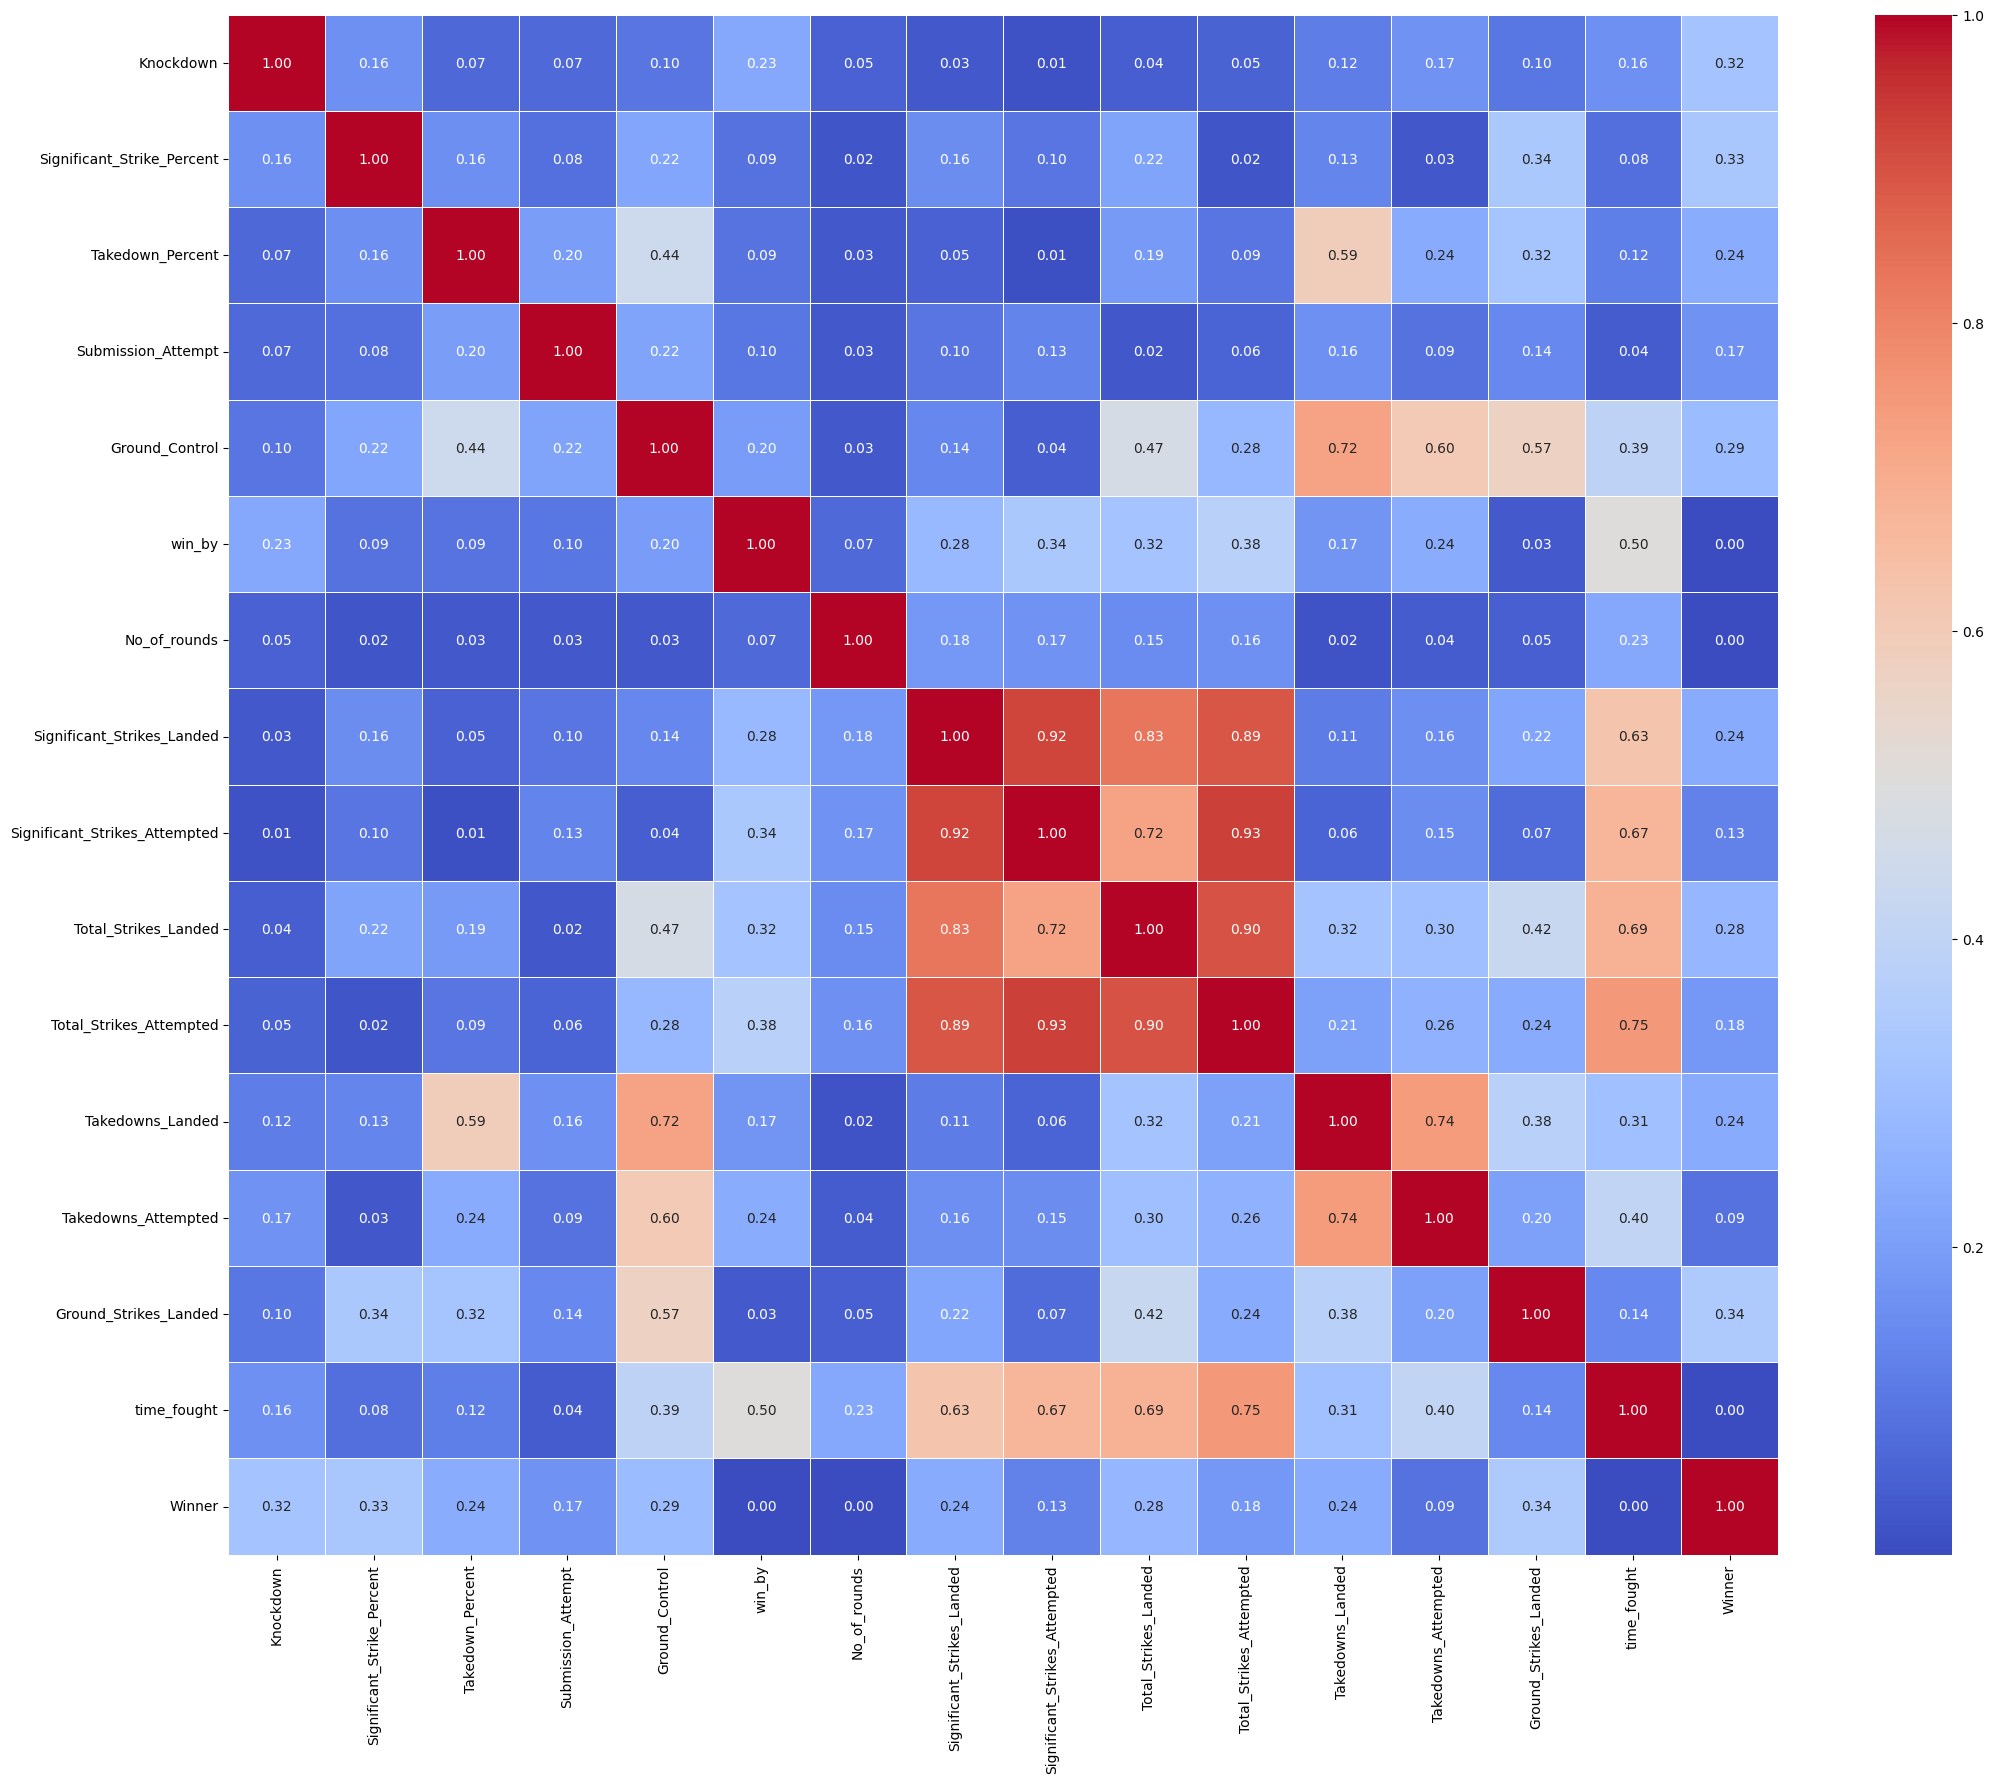

In [53]:
plt.figure(figsize=(25, 20))
corr_matrix = ufc.corr(method='pearson', numeric_only=True).abs()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)


In [54]:
sol = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1)
                 .astype(bool))  # Use `bool` instead of `np.bool`
                 .stack()
                 .sort_values(ascending=False))

# Print the top 10 highest correlations
print(sol[0:10])

Significant_Strikes_Attempted  Total_Strikes_Attempted          0.931540
Significant_Strikes_Landed     Significant_Strikes_Attempted    0.921924
Total_Strikes_Landed           Total_Strikes_Attempted          0.901947
Significant_Strikes_Landed     Total_Strikes_Attempted          0.892140
                               Total_Strikes_Landed             0.829379
Total_Strikes_Attempted        time_fought                      0.750464
Takedowns_Landed               Takedowns_Attempted              0.743088
Ground_Control                 Takedowns_Landed                 0.723853
Significant_Strikes_Attempted  Total_Strikes_Landed             0.723201
Total_Strikes_Landed           time_fought                      0.685181
dtype: float64


In [55]:
ufc.isna().sum()

fighter                          0
Knockdown                        0
Significant_Strike_Percent       0
Takedown_Percent                 0
Submission_Attempt               0
Ground_Control                   0
win_by                           0
No_of_rounds                     0
date                             0
Fight_type                       0
Significant_Strikes_Landed       0
Significant_Strikes_Attempted    0
Total_Strikes_Landed             0
Total_Strikes_Attempted          0
Takedowns_Landed                 0
Takedowns_Attempted              0
Ground_Strikes_Landed            0
time_fought                      0
Winner                           0
dtype: int64

Need to create a gender column, to separate women and men's weight divisions

create a new column 'gender' in dataframe, and If column 'Fight_type' is W Strawweight or W Flyweight or W Bantamweight or W Featherweight, put the value 0 else make it 1.

In [56]:
def assign_gender(row):
    women_weights = ['W Strawweight', 'W Flyweight', 'W Bantamweight', 'W Featherweight']
    if row['Fight_type'] in women_weights:
        return 0
    else:
        return 1

In [57]:
ufc.insert(len(ufc.columns) - 1, 'Gender', ufc.apply(assign_gender, axis=1))

Removing all catch weight fights, because of convenience.

In [58]:
ufc = ufc[ufc['Fight_type'] != 'Catch Weight']

Changing weight division from names to numbers, so the model can process it.

In [59]:
mapping = {
    'W Strawweight': 115,
    'W Flyweight': 125,
    'W Bantamweight': 135,
    'W Featherweight': 145,
    'Flyweight': 125,
    'Bantamweight': 135,
    'Featherweight': 145,
    'Lightweight': 155,
    'Welterweight': 170,
    'Middleweight': 185,
    'Light Heavyweight': 205,
    'Heavyweight': 265,
}
pd.set_option('future.no_silent_downcasting', True)
ufc['Fight_type'] = ufc['Fight_type'].replace(mapping)

In [60]:
ufc.rename(columns={'Fight_type': 'Weight Division'}, inplace=True)

In [61]:
ufc.head()

,fighter,Knockdown,Significant_Strike_Percent,Takedown_Percent,Submission_Attempt,Ground_Control,win_by,No_of_rounds,date,Weight Division,Significant_Strikes_Landed,Significant_Strikes_Attempted,Total_Strikes_Landed,Total_Strikes_Attempted,Takedowns_Landed,Takedowns_Attempted,Ground_Strikes_Landed,time_fought,Gender,Winner
0,Nate Landwehr,0,38,0,0,42,10,3,2024-12-07,145,21,55,27,64,0,0,0,801,1,0
1,Vicente Luque,0,33,0,1,14,9,3,2024-12-07,170,2,6,2,6,0,0,0,52,1,1
2,Lukasz Brzeski,0,46,0,0,0,10,3,2024-12-07,265,32,69,32,69,0,2,0,291,1,0
3,Max Griffin,0,29,0,0,79,9,3,2024-12-07,170,10,34,18,43,0,1,0,716,1,0
4,Chase Hooper,0,46,50,1,128,9,3,2024-12-07,155,7,15,14,28,3,6,1,221,1,1


In [62]:
date_column = ufc['date']  # Extract the 'date' column
ufc.drop(columns=['date'], inplace=True)  # Remove the 'date' column from its current position
ufc.insert(0, 'date', date_column)  # Insert the 'date' column at the first position


In [63]:
ufc.describe()

,Knockdown,Significant_Strike_Percent,Takedown_Percent,Submission_Attempt,Ground_Control,win_by,No_of_rounds,Significant_Strikes_Landed,Significant_Strikes_Attempted,Total_Strikes_Landed,Total_Strikes_Attempted,Takedowns_Landed,Takedowns_Attempted,Ground_Strikes_Landed,time_fought,Gender,Winner
count,14878.000000,14878.000000,14878.000000,14878.000000,14878.000000,14878.000000,14878.000000,14878.000000,14878.000000,14878.000000,14878.000000,14878.000000,14878.000000,14878.000000,14878.000000,14878.000000,14878.000000
mean,0.217906,45.341040,26.392190,0.383049,134.196868,9.111843,3.180669,37.400121,84.074674,55.408523,104.696935,1.071851,2.856768,4.941928,642.424519,0.892459,0.499798
std,0.495428,16.444736,35.103368,0.828835,174.681690,0.844974,0.573341,32.321066,70.634311,44.267620,78.554040,1.696510,3.750878,9.078848,360.937493,0.309811,0.500017
min,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000,0.000000
25%,0.000000,35.000000,0.000000,0.000000,6.000000,9.000000,3.000000,13.000000,29.000000,20.000000,40.000000,0.000000,0.000000,0.000000,288.000000,1.000000,0.000000
50%,0.000000,45.000000,0.000000,0.000000,60.000000,9.000000,3.000000,30.000000,67.000000,47.000000,93.000000,0.000000,1.000000,1.000000,854.000000,1.000000,0.000000
75%,0.000000,55.000000,50.000000,0.000000,199.000000,10.000000,3.000000,53.000000,121.000000,80.000000,153.000000,2.000000,4.000000,6.000000,900.000000,1.000000,1.000000
max,5.000000,100.000000,100.000000,10.000000,1342.000000,10.000000,5.000000,445.000000,744.000000,447.000000,746.000000,21.000000,49.000000,136.000000,1500.000000,1.000000,1.000000


In [64]:
ufc.head()

,date,fighter,Knockdown,Significant_Strike_Percent,Takedown_Percent,Submission_Attempt,Ground_Control,win_by,No_of_rounds,Weight Division,Significant_Strikes_Landed,Significant_Strikes_Attempted,Total_Strikes_Landed,Total_Strikes_Attempted,Takedowns_Landed,Takedowns_Attempted,Ground_Strikes_Landed,time_fought,Gender,Winner
0,2024-12-07,Nate Landwehr,0,38,0,0,42,10,3,145,21,55,27,64,0,0,0,801,1,0
1,2024-12-07,Vicente Luque,0,33,0,1,14,9,3,170,2,6,2,6,0,0,0,52,1,1
2,2024-12-07,Lukasz Brzeski,0,46,0,0,0,10,3,265,32,69,32,69,0,2,0,291,1,0
3,2024-12-07,Max Griffin,0,29,0,0,79,9,3,170,10,34,18,43,0,1,0,716,1,0
4,2024-12-07,Chase Hooper,0,46,50,1,128,9,3,155,7,15,14,28,3,6,1,221,1,1


In [65]:
ufc2 = ufc.copy()
ufc2.head()

# List of values to remove
values_to_remove = [
    'Road To    Bantamweight',
    'Road To    Featherweight',
    'Road To    Lightweight',
    'Road to    Flyweight'
]

# Remove rows with these values
ufc2 = ufc2[~ufc2['Weight Division'].isin(values_to_remove)]

# Convert 'Weight Division' to numeric
ufc2['Weight Division'] = pd.to_numeric(ufc2['Weight Division'])

# Verify the changes
print("Unique values in 'Weight Division' after cleaning:")
print(ufc2['Weight Division'].unique())
print("\nData type of 'Weight Division' after cleaning:", ufc2['Weight Division'].dtype)

# Print the new shape of the dataframe
print("\nNew shape of the dataframe:", ufc2.shape)

Unique values in 'Weight Division' after cleaning:
[145 170 265 155 125 205 115 135 185]

Data type of 'Weight Division' after cleaning: int64

New shape of the dataframe: (14870, 20)


# **Standardization**

In [66]:
print(ufc2.columns[2:-1].tolist())

['Knockdown', 'Significant_Strike_Percent', 'Takedown_Percent', 'Submission_Attempt', 'Ground_Control', 'win_by', 'No_of_rounds', 'Weight Division', 'Significant_Strikes_Landed', 'Significant_Strikes_Attempted', 'Total_Strikes_Landed', 'Total_Strikes_Attempted', 'Takedowns_Landed', 'Takedowns_Attempted', 'Ground_Strikes_Landed', 'time_fought', 'Gender']


In [67]:
def calculate_avg_attributes(dataframe, years):
    df_temp = dataframe.sort_values('date', ascending=False)  # Sort by date in descending order

    grouped_df = df_temp.groupby('fighter').head(years)  # Select up to 'years' number of rows for each fighter

    exclude_columns = ['Weight Division', 'Gender']
    avg_attributes = grouped_df.groupby('fighter').apply(lambda x: x.mean(numeric_only=True) if len(x) > 0 else pd.Series())
    
    # Update 'Weight Division' and 'Gender' columns with the last (latest) value
    last_values = grouped_df.groupby('fighter')[exclude_columns].last()
    avg_attributes[exclude_columns] = last_values
    
    avg_attributes = avg_attributes.reset_index()
    return avg_attributes


In [68]:
columns_to_standardize = ufc2.columns[2:-1].tolist()

scaler = StandardScaler()
scaler.fit(ufc2[columns_to_standardize])

ufc2[columns_to_standardize] = scaler.transform(ufc2[columns_to_standardize])

In [69]:
ufc2.head()

,date,fighter,Knockdown,Significant_Strike_Percent,Takedown_Percent,Submission_Attempt,Ground_Control,win_by,No_of_rounds,Weight Division,Significant_Strikes_Landed,Significant_Strikes_Attempted,Total_Strikes_Landed,Total_Strikes_Attempted,Takedowns_Landed,Takedowns_Attempted,Ground_Strikes_Landed,time_fought,Gender,Winner
0,2024-12-07,Nate Landwehr,-0.439804,-0.446357,-0.751962,-0.462152,-0.527768,1.051386,-0.315221,-0.603658,-0.507603,-0.411841,-0.641891,-0.518251,-0.631834,-0.761970,-0.544400,0.439228,0.347236,0
1,2024-12-07,Vicente Luque,-0.439804,-0.750383,-0.751962,0.744556,-0.688071,-0.132478,-0.315221,0.052876,-1.095373,-1.105463,-1.206576,-1.256508,-0.631834,-0.761970,-0.544400,-1.635943,0.347236,1
2,2024-12-07,Lukasz Brzeski,-0.439804,0.040086,-0.751962,-0.462152,-0.768222,1.051386,-0.315221,2.547703,-0.167315,-0.213663,-0.528954,-0.454608,-0.631834,-0.228419,-0.544400,-0.973773,0.347236,0
3,2024-12-07,Max Griffin,-0.439804,-0.993605,-0.751962,-0.462152,-0.315939,-0.132478,-0.315221,0.052876,-0.847891,-0.709107,-0.845177,-0.785551,-0.631834,-0.495194,-0.544400,0.203727,0.347236,0
4,2024-12-07,Chase Hooper,-0.439804,0.040086,0.672212,0.744556,-0.035409,-0.132478,-0.315221,-0.341044,-0.940697,-0.978063,-0.935527,-0.976480,1.136541,0.838684,-0.434241,-1.167714,0.347236,1


In [70]:
# Define the path where the scaler will be saved
SCALER_PATH = './models/scaler.joblib'  # You can change the path as needed

# Ensure the 'models' directory exists
import os
os.makedirs(os.path.dirname(SCALER_PATH), exist_ok=True)

# Save the scaler
joblib.dump(scaler, SCALER_PATH)

print(f"Scaler successfully saved to {SCALER_PATH}")

Scaler successfully saved to ./models/scaler.joblib


In [71]:
with open('./data/raw_total_fight_data.csv', 'r') as file:
    for _ in range(5):
        line = file.readline()
        print(line)

R_fighter;B_fighter;R_KD;B_KD;R_SIG_STR.;B_SIG_STR.;R_SIG_STR_pct;B_SIG_STR_pct;R_TOTAL_STR.;B_TOTAL_STR.;R_TD;B_TD;R_TD_pct;B_TD_pct;R_SUB_ATT;B_SUB_ATT;R_REV;B_REV;R_CTRL;B_CTRL;R_HEAD;B_HEAD;R_BODY;B_BODY;R_LEG;B_LEG;R_DISTANCE;B_DISTANCE;R_CLINCH;B_CLINCH;R_GROUND;B_GROUND;win_by;last_round;last_round_time;Format;Referee;date;location;Fight_type;Winner

Nate Landwehr;Dooho Choi;0;0;21 of 55;63 of 95;38%;66%;27 of 64;66 of 98;0 of 0;3 of 4;---;75%;0;0;0;0;0:42;4:24;9 of 35;47 of 78;9 of 15;9 of 9;3 of 5;7 of 8;11 of 43;56 of 88;10 of 12;4 of 4;0 of 0;3 of 3;KO/TKO;3;3:21;3 Rnd (5-5-5);Chris Tognoni;December 07, 2024;Las Vegas, Nevada, USA;Featherweight Bout;Dooho Choi

Vicente Luque;Themba Gorimbo;0;0;2 of 6;5 of 9;33%;55%;2 of 6;5 of 9;0 of 0;0 of 0;---;---;1;0;0;0;0:14;0:00;1 of 4;1 of 5;0 of 0;1 of 1;1 of 2;3 of 3;2 of 6;5 of 9;0 of 0;0 of 0;0 of 0;0 of 0;Submission;1;0:52;3 Rnd (5-5-5);Mark Smith;December 07, 2024;Las Vegas, Nevada, USA;Welterweight Bout;Vicente Luque

Dominick 

# **Train Test Split**

In [72]:
X = ufc2.iloc[:, 2:-1].values
y = ufc2.iloc[:, -1].values

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# **Logistic Regression Model**

In [74]:
from sklearn.linear_model import LogisticRegression
lr_classifier = LogisticRegression(random_state = 0)
lr_classifier.fit(X_train, y_train)

LogisticRegression(random_state=0)

In [75]:
y_pred = lr_classifier.predict(X_test)
print(y_pred)

[0 1 1 ... 1 0 1]


In [76]:
new_y_pred = y_pred.reshape(len(y_pred),1)
new_y_test = y_test.reshape(len(y_test),1)
np.concatenate((new_y_pred,new_y_test),1)

array([[0, 0],
       [1, 1],
       [1, 1],
       ...,
       [1, 0],
       [0, 0],
       [1, 1]])

In [77]:
from sklearn.metrics import confusion_matrix, accuracy_score
accuracy_score(y_test, y_pred)
cm1 = confusion_matrix(y_pred, y_test)
print(cm1)
print(accuracy_score(y_test, y_pred))

[[1200  334]
 [ 288 1152]]
0.7908540685944856


# **Random Forest Model**

In [78]:
from sklearn.ensemble import RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators = 50, criterion = 'entropy', random_state = 0)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=50, random_state=0)

In [79]:
y_pred = rf_classifier.predict(X_test)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

[[0 0]
 [1 1]
 [1 1]
 ...
 [0 0]
 [0 0]
 [1 1]]


In [80]:
cm2 = confusion_matrix(y_test, y_pred)
print(cm2)
accuracy_score(y_test, y_pred)

[[1193  295]
 [ 221 1265]]


0.8264963012777404

# **Decision Tree Model**

In [81]:
from sklearn.tree import DecisionTreeClassifier
dt_classifier = DecisionTreeClassifier(criterion = 'gini', random_state = 0)
dt_classifier.fit(X_train, y_train)

DecisionTreeClassifier(random_state=0)

In [82]:
y_pred = dt_classifier.predict(X_test)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

[[1 0]
 [1 1]
 [1 1]
 ...
 [1 0]
 [1 0]
 [1 1]]


In [83]:
cm3 = confusion_matrix(y_test, y_pred)
print(cm3)
accuracy_score(y_test, y_pred)

[[1128  360]
 [ 324 1162]]


0.7700067249495629

# **Naive Bayes Model**

In [84]:
from sklearn.naive_bayes import GaussianNB
nb_classifier = GaussianNB()
nb_classifier.fit(X_train, y_train)

GaussianNB()

In [85]:
y_pred = nb_classifier.predict(X_test)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

[[0 0]
 [1 1]
 [1 1]
 ...
 [0 0]
 [0 0]
 [1 1]]


In [86]:
cm4 = confusion_matrix(y_test, y_pred)
print(cm4)
accuracy_score(y_test, y_pred)

[[1190  298]
 [ 450 1036]]


0.7484868863483524

# **KNN Model**

In [87]:
from sklearn.neighbors import KNeighborsClassifier
knn_classifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)

# n_neighbours = number of neighbours, metric = & = =2 to take euclidean distance
# euclidean distance is basically the geometric distance between 2 points
# p =1 = some other method under minkowski

knn_classifier.fit(X_train, y_train)

KNeighborsClassifier()

In [88]:
y_pred = knn_classifier.predict(X_test)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

[[1 0]
 [0 1]
 [1 1]
 ...
 [0 0]
 [0 0]
 [0 1]]


In [89]:
cm5 = confusion_matrix(y_test, y_pred)
print(cm5)
accuracy_score(y_test, y_pred)

[[1158  330]
 [ 276 1210]]


0.7962340282447882

# **SVM Model**

In [90]:
from sklearn.svm import SVC
svm_classifier = SVC(kernel = 'linear', random_state = 0)
svm_classifier.fit(X_train, y_train)

SVC(kernel='linear', random_state=0)

In [91]:
y_pred = svm_classifier.predict(X_test)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

[[0 0]
 [1 1]
 [1 1]
 ...
 [0 0]
 [0 0]
 [1 1]]


In [92]:
cm6 = confusion_matrix(y_test, y_pred)
print(cm6)
accuracy_score(y_test, y_pred)

[[1192  296]
 [ 324 1162]]


0.7915265635507733

# **Prediction System**

In [93]:
ufc3 = ufc2.copy()

In [94]:
to_drop = ['Winner']


In [95]:
ufc3 = ufc3.drop(to_drop, axis=1)

In [96]:
ufc3.head()

,date,fighter,Knockdown,Significant_Strike_Percent,Takedown_Percent,Submission_Attempt,Ground_Control,win_by,No_of_rounds,Weight Division,Significant_Strikes_Landed,Significant_Strikes_Attempted,Total_Strikes_Landed,Total_Strikes_Attempted,Takedowns_Landed,Takedowns_Attempted,Ground_Strikes_Landed,time_fought,Gender
0,2024-12-07,Nate Landwehr,-0.439804,-0.446357,-0.751962,-0.462152,-0.527768,1.051386,-0.315221,-0.603658,-0.507603,-0.411841,-0.641891,-0.518251,-0.631834,-0.761970,-0.544400,0.439228,0.347236
1,2024-12-07,Vicente Luque,-0.439804,-0.750383,-0.751962,0.744556,-0.688071,-0.132478,-0.315221,0.052876,-1.095373,-1.105463,-1.206576,-1.256508,-0.631834,-0.761970,-0.544400,-1.635943,0.347236
2,2024-12-07,Lukasz Brzeski,-0.439804,0.040086,-0.751962,-0.462152,-0.768222,1.051386,-0.315221,2.547703,-0.167315,-0.213663,-0.528954,-0.454608,-0.631834,-0.228419,-0.544400,-0.973773,0.347236
3,2024-12-07,Max Griffin,-0.439804,-0.993605,-0.751962,-0.462152,-0.315939,-0.132478,-0.315221,0.052876,-0.847891,-0.709107,-0.845177,-0.785551,-0.631834,-0.495194,-0.544400,0.203727,0.347236
4,2024-12-07,Chase Hooper,-0.439804,0.040086,0.672212,0.744556,-0.035409,-0.132478,-0.315221,-0.341044,-0.940697,-0.978063,-0.935527,-0.976480,1.136541,0.838684,-0.434241,-1.167714,0.347236


**Approach and Assumptions**

Now, to make a prediction IRL, I will only have 'names' of the fighters', but our model requires all other attributes as well. So what I am doing is, taking the mean value of all other attributes from a fighter's last 3 fights, as I feel like it's a good reflection of how the fighter is doing at any given point. If the fighter does not have 3 fights already in the UFC, I'll take mean of 2 fights, and if even that is not there then I will go with the values of just there first fight. 

In [97]:
ufc3.columns.tolist()

['date',
 'fighter',
 'Knockdown',
 'Significant_Strike_Percent',
 'Takedown_Percent',
 'Submission_Attempt',
 'Ground_Control',
 'win_by',
 'No_of_rounds',
 'Weight Division',
 'Significant_Strikes_Landed',
 'Significant_Strikes_Attempted',
 'Total_Strikes_Landed',
 'Total_Strikes_Attempted',
 'Takedowns_Landed',
 'Takedowns_Attempted',
 'Ground_Strikes_Landed',
 'time_fought',
 'Gender']

In [98]:
def calculate_avg_attributes(dataframe, years):
    df_temp = dataframe.sort_values('date', ascending=False)  # Sort by date in descending order

    grouped_df = df_temp.groupby('fighter').head(years)  # Select up to 'years' number of rows for each fighter

    exclude_columns = ['Weight Division', 'Gender']
    avg_attributes = grouped_df.groupby('fighter').apply(lambda x: x.mean(numeric_only=True) if len(x) > 0 else pd.Series())
    
    # Update 'Weight Division' and 'Gender' columns with the last (latest) value
    last_values = grouped_df.groupby('fighter')[exclude_columns].last()
    avg_attributes[exclude_columns] = last_values
    
    avg_attributes = avg_attributes.reset_index()
    return avg_attributes


In [99]:
avg_attributes_df = calculate_avg_attributes(ufc3, 3)

/var/folders/gy/n2hps2kd1kg7ng24xwgchvhr0000gn/T/ipykernel_21090/346538165.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  avg_attributes = grouped_df.groupby('fighter').apply(lambda x: x.mean(numeric_only=True) if len(x) > 0 else pd.Series())


In [100]:
# Define the output path for the cleaned CSV
CLEANED_DATA_PATH = './data/avg_attributes.csv'  # You can change the path as needed

# Export the cleaned DataFrame to CSV
avg_attributes_df.to_csv(CLEANED_DATA_PATH, index=False)

In [101]:
avg_attributes_df.head()

,fighter,Knockdown,Significant_Strike_Percent,Takedown_Percent,Submission_Attempt,Ground_Control,win_by,No_of_rounds,Weight Division,Significant_Strikes_Landed,Significant_Strikes_Attempted,Total_Strikes_Landed,Total_Strikes_Attempted,Takedowns_Landed,Takedowns_Attempted,Ground_Strikes_Landed,time_fought,Gender
0,Alatengheili,0.233231,-0.385552,0.244960,-0.462152,0.561911,-0.527100,-0.315221,-0.866271,-0.394173,-0.213663,0.163726,0.194549,0.743568,0.749759,-0.397522,-0.074255,0.347236
1,Aoriqileng,0.906267,0.830555,0.672212,-0.462152,0.061918,0.262143,-0.315221,-0.866271,0.420456,0.045855,0.788644,0.393964,-0.042376,-0.050568,0.924382,0.037492,0.347236
2,Maheshate,0.906267,-0.081525,-0.751962,-0.462152,-0.768222,0.656765,-0.315221,-0.341044,-0.177626,0.168537,-0.498837,-0.089722,-0.631834,-0.584120,-0.544400,-0.458443,0.347236
3,Mizuki,-0.439804,0.404918,0.672212,-0.462152,0.439775,-0.132478,-0.315221,-1.391498,0.544197,0.295937,0.623004,0.449121,-0.042376,-0.228419,-0.434241,0.713516,-2.879887
4,Rongzhu,0.233231,0.404918,0.197487,-0.462152,0.374891,0.262143,-0.315221,-0.341044,0.729808,0.465803,0.495008,0.432150,0.743568,0.305132,1.034540,0.186180,0.347236


In [102]:
def get_fighter_row(dataframe, fighter_name):
    row = dataframe.loc[dataframe['fighter'] == fighter_name]
    row_values = row.values.flatten()[1:]  # Exclude the 'fighter' column
    return row_values

Since **Random Forest** had the best results, I am taking it to make calculate the probability of a fighter winning their next fight.

In [119]:
def get_win_probability(fighter_name):
    fighter_name = fighter_name
    fighter_row = get_fighter_row(avg_attributes_df, fighter_name)
    win_prob = rf_classifier.predict_proba([fighter_row])[0][1]
    return win_prob

**Add name of a fighter to get the probability of them winning their next fight.**


In [120]:
get_win_probability("Sean Strickland")

np.float64(0.66)

In [121]:
def match_probability(fighter_A, fighter_B):
    fighter_A = fighter_A
    fighter_B = fighter_B
    prob_A = get_win_probability(fighter_A)
    prob_B = get_win_probability(fighter_B)
    total_prob = prob_A + prob_B
    probability_A = round(prob_A / total_prob, 2)
    probability_B = round(prob_B / total_prob, 2)
    return probability_A, probability_B


Add 2 names here.

In [127]:
match_probability('Ciryl Gane', 'Alexander Volkov')

(np.float64(0.61), np.float64(0.39))

In [128]:
match_probability("Shavkat Rakhmonov", "Ian Machado Garry")

(np.float64(0.61), np.float64(0.39))

In [107]:
import joblib
import os

# Define the models directory
models_dir = './models/'
os.makedirs(models_dir, exist_ok=True)

# Save Logistic Regression model
lr_model_path = os.path.join(models_dir, 'lr_model.joblib')
joblib.dump(lr_classifier, lr_model_path)
print(f"Logistic Regression model saved to {lr_model_path}")

# Save Random Forest model
rf_model_path = os.path.join(models_dir, 'rf_model.joblib')
joblib.dump(rf_classifier, rf_model_path)
print(f"Random Forest model saved to {rf_model_path}")

# Save Decision Tree model
dt_model_path = os.path.join(models_dir, 'dt_model.joblib')
joblib.dump(dt_classifier, dt_model_path)
print(f"Decision Tree model saved to {dt_model_path}")

# Save Naive Bayes model
nb_model_path = os.path.join(models_dir, 'nb_model.joblib')
joblib.dump(nb_classifier, nb_model_path)
print(f"Naive Bayes model saved to {nb_model_path}")

# Save KNN model
knn_model_path = os.path.join(models_dir, 'knn_model.joblib')
joblib.dump(knn_classifier, knn_model_path)
print(f"KNN model saved to {knn_model_path}")

# Save SVM model
svm_model_path = os.path.join(models_dir, 'svm_model.joblib')
joblib.dump(svm_classifier, svm_model_path)
print(f"SVM model saved to {svm_model_path}")

Logistic Regression model saved to ./models/lr_model.joblib
Random Forest model saved to ./models/rf_model.joblib
Decision Tree model saved to ./models/dt_model.joblib
Naive Bayes model saved to ./models/nb_model.joblib
KNN model saved to ./models/knn_model.joblib
SVM model saved to ./models/svm_model.joblib


In [108]:
import json
import os

CLEANED_DATA_PATH = './data/avg_attributes.csv'

required_columns = ['Gender', 'fighter']
missing_columns = [col for col in required_columns if col not in avg_attributes_df.columns]

if missing_columns:
    print(f"Error: The following required columns are missing in the DataFrame: {missing_columns}")
    exit(1)
else:
    print("\nBoth 'Gender' and 'fighter' columns are present.")

female_fighters_df = avg_attributes_df[avg_attributes_df['Gender'] < 0]
male_fighters_df = avg_attributes_df[avg_attributes_df['Gender'] > 0]  # Changed from >= 0 to > 0

female_fighters = female_fighters_df['fighter'].drop_duplicates().sort_values().tolist()
male_fighters = male_fighters_df['fighter'].drop_duplicates().sort_values().tolist()

print("\nSample Female Fighters:", female_fighters[:5])
print("Sample Male Fighters:", male_fighters[:5])

FEMALE_FIGHTERS_JSON_PATH = './data/female_fighters.json'
MALE_FIGHTERS_JSON_PATH = './data/male_fighters.json'

def export_fighters_to_json(fighter_list, json_path):
    """
    Exports a list of fighter names to a JSON file.
    
    Parameters:
    - fighter_list (list): List of fighter names.
    - json_path (str): Path to save the JSON file.
    """
    try:
        # Ensure the directory exists
        os.makedirs(os.path.dirname(json_path), exist_ok=True)
        
        # Export to JSON
        with open(json_path, 'w') as json_file:
            json.dump(fighter_list, json_file, indent=4)
        
        print(f"Fighter names successfully exported to {json_path}")
    except Exception as e:
        print(f"An error occurred while exporting to {json_path}: {e}")

export_fighters_to_json(female_fighters, FEMALE_FIGHTERS_JSON_PATH)
export_fighters_to_json(male_fighters, MALE_FIGHTERS_JSON_PATH)


Both 'Gender' and 'fighter' columns are present.

Sample Female Fighters: [' Mizuki', 'Ailin Perez', 'Aisling Daly', 'Aleksandra Albu', 'Alex Chambers']
Sample Male Fighters: [' Alatengheili', ' Aoriqileng', ' Maheshate', ' Rongzhu', ' Sumudaerji']
Fighter names successfully exported to ./data/female_fighters.json
Fighter names successfully exported to ./data/male_fighters.json


In [109]:
import pandas as pd
from datetime import datetime, timedelta
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def calculate_model_accuracy():
    """
    Calculates the accuracy percentage of the Random Forest model predictions
    for fights in the past year by comparing the predicted winners to the actual winners.
    Additionally, displays a confusion matrix and a bar chart of correct vs. incorrect predictions.
    
    Returns:
        float: Accuracy percentage of the model.
    """
    # Path to the raw fight data CSV
    data_path = './data/raw_total_fight_data.csv'
    
    # Load the fight data
    try:
        df = pd.read_csv(data_path, sep=';')
        print("Fight data loaded successfully.")
    except Exception as e:
        print(f"Error loading data: {e}")
        return 0.0
    
    # Parse the 'date' column to datetime
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    
    # Define the date one year ago from today
    one_year_ago = datetime.now() - timedelta(days=365)
    
    # Filter fights from the past year
    recent_fights = df[df['date'] >= one_year_ago]
    
    # Check if there are any recent fights
    if recent_fights.empty:
        print("No fights found in the past year.")
        return 0.0
    
    print(f"Number of fights in the past year: {len(recent_fights)}")
    
    # Define feature columns required by the model
    feature_columns = [
        'R_KD', 'B_KD', 'R_SIG_STR.', 'B_SIG_STR.', 'R_SIG_STR_pct', 'B_SIG_STR_pct',
        'R_TOTAL_STR.', 'B_TOTAL_STR.', 'R_TD', 'B_TD', 'R_TD_pct', 'B_TD_pct',
        'R_SUB_ATT', 'B_SUB_ATT', 'R_REV', 'B_REV', 'R_CTRL', 'B_CTRL',
        'R_HEAD', 'B_HEAD', 'R_BODY', 'B_BODY', 'R_LEG', 'B_LEG',
        'R_DISTANCE', 'B_DISTANCE', 'R_CLINCH', 'B_CLINCH',
        'R_GROUND', 'B_GROUND'
    ]
    
    # Check for missing feature columns
    missing_features = [col for col in feature_columns if col not in recent_fights.columns]
    if missing_features:
        print(f"Missing feature columns: {missing_features}")
        return 0.0
    
    # Extract features and handle missing values
    X = recent_fights[feature_columns].fillna(0)
    
    # Load the Random Forest model
    model_path = './models/rf_model.joblib'
    try:
        rf_model = joblib.load(model_path)
        print("Random Forest model loaded successfully.")
    except Exception as e:
        print(f"Error loading model: {e}")
        return 0.0
    
    # Make predictions
    try:
        predictions = rf_model.predict(X)
        print("Model predictions completed.")
    except Exception as e:
        print(f"Error during prediction: {e}")
        return 0.0
    
    # Map predictions to 'R_fighter' or 'B_fighter'
    predicted_classes = predictions  # Assuming predictions are already 'R_fighter' or 'B_fighter'
    
    # Map actual winners to 'R_fighter' or 'B_fighter'
    actual_classes = recent_fights.apply(
        lambda row: 'R_fighter' if row['Winner'] == row['R_fighter'] else 'B_fighter',
        axis=1
    )
    
    # Calculate the number of correct predictions
    correct_predictions = (predicted_classes == actual_classes).sum()
    total_predictions = len(predicted_classes)
    
    # Calculate accuracy percentage
    accuracy = (correct_predictions / total_predictions) * 100
    
    print(f"Model Accuracy in the Past Year: {accuracy:.2f}% ({correct_predictions}/{total_predictions} correct predictions)")
    
    # Visualization: Confusion Matrix
    plt.figure(figsize=(6, 5))
    cm = confusion_matrix(actual_classes, predicted_classes, labels=['R_fighter', 'B_fighter'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['R_fighter Predicted', 'B_fighter Predicted'], yticklabels=['R_fighter Actual', 'B_fighter Actual'])
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Class')
    plt.xlabel('Predicted Class')
    plt.show()
    
    # Visualization: Accuracy Bar Chart
    labels = ['Correct Predictions', 'Incorrect Predictions']
    counts = [correct_predictions, total_predictions - correct_predictions]
    
    plt.figure(figsize=(6, 4))
    sns.barplot(x=labels, y=counts, palette=['green', 'red'])
    plt.title('Model Prediction Accuracy')
    plt.ylabel('Number of Fights')
    for index, value in enumerate(counts):
        plt.text(index, value + 0.5, str(value), ha='center')
    plt.ylim(0, max(counts) * 1.1)  # Add some space on top for the labels
    plt.show()
    
    return accuracy

calculate_model_accuracy()

Fight data loaded successfully.
Number of fights in the past year: 523
Random Forest model loaded successfully.
Error during prediction: could not convert string to float: '21 of 55'


/Users/bensonyan/Desktop/projects/ufc/.venv/lib/python3.13/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


0.0